# Isochrone walking Maps

for Vienna (three different types of illustration)

based on https://github.com/gboeing/osmnx-examples/blob/main/notebooks/13-isolines-isochrones.ipynb

In [1]:
import common_options as co
import helpers as h

import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from descartes import PolygonPatch
from shapely.geometry import Point, LineString, Polygon
%matplotlib inline
ox.config(log_console=True)
ox.__version__


'1.1.0'

In [2]:
point = 48.21804893535993, 16.392888584694294
dist = 6500
trip_times = [5, 15, 25, 40, 60] #in minutes
travel_speed = 4.5 #walking speed in km/hour

In [3]:
# download the street network
G = ox.graph_from_point(point, dist, custom_filter=co.walking_filter, **co.graph_download_options)


In [4]:
# find the centermost node and then project the graph to UTM
center_node = ox.nearest_nodes(G, [point[1]], [point[0]])[0]
G = ox.project_graph(G)


In [5]:
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute


In [6]:
iso_colors = co.col_greens_5

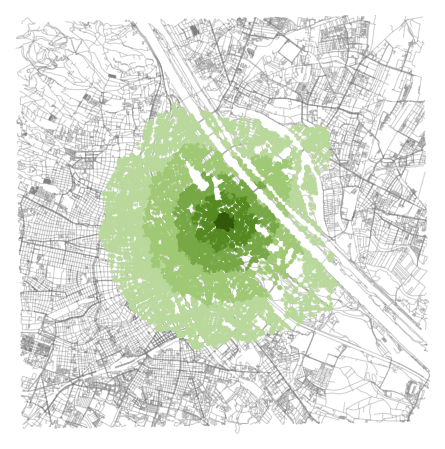

In [7]:
# node illustration
# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [15 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, close=False, node_color=nc, node_size=ns, node_alpha=0.8,
                        bgcolor='white', edge_color=co.col_lightgray, edge_alpha=0.2, show=False)
h.save_and_show(fig, 'city_isochrone_dots')

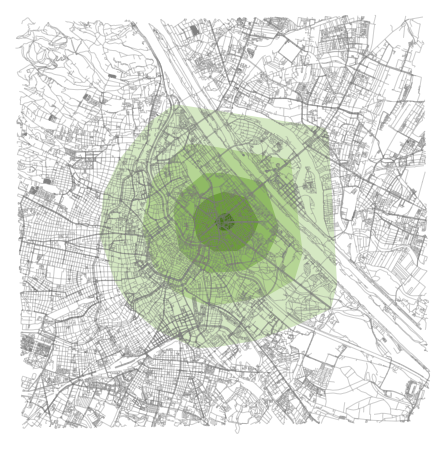

In [8]:
# polygon illustration
# make the isochrone polygons
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)
# plot the network then add isochrones as colored descartes polygon patches
fig, ax = ox.plot_graph(G, show=False, close=False, **co.graph_plot_options)
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)

h.save_and_show(fig, 'city_isochrone_polygones')

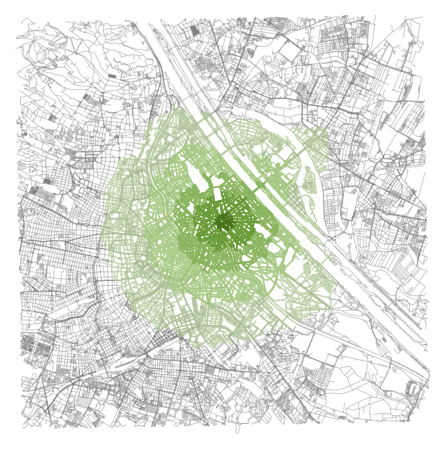

In [9]:
# network illustration
# plot isochrones as buffer without fillings

def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')

        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({'id': list(subgraph.nodes)}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index('id')

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get('geometry',  LineString([f,t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union
        
        
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys

isochrone_polys = make_iso_polys(G, edge_buff=25, node_buff=0, infill=False)
fig, ax = ox.plot_graph(G, show=False, close=False, **co.graph_plot_options)
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=1)
    ax.add_patch(patch)

h.save_and_show(fig, 'city_isochrone_buffer')